# 混合型基金数据分析
## 项目背景
随着人均收入水平和家庭财富的逐步增长，人们对于理财的需求日趋旺盛，而受2020年新冠肺炎疫情影响，居民的投资理财意识被进一步激发。作为优质标的，操作难度适中的公募基金投资方式受到了广大居民的追捧，而作为占据整个公募基金利润总额半壁江山的混合型公募基金，其投资动态和持仓变化较大程度地决定了国家金融市场的稳定发展以及个人家庭理财的收益，所以对于混合型公募基金的数据分析就变得尤为重要。
## 项目简介
本项目使用Python采集和分析了[天天基金网](https://fund.eastmoney.com/)于2021年3月16日更新的混合型公募基金数据，由于电脑内存和性能的限制，项目只截取了近2年累计收益率在前100的混合型基金数据作为项目分析数据集。通过分析基金收益现状和持仓变化的趋势，做出基于分析的投资建议和策略。
## 分析步骤
- 提出问题
- 数据采集
- 数据评估与清洗
- 探索性分析
    - 基金部分
    - 股票部分
- 结论和建议

## 提出问题
本项目将需要探索的问题归纳为两个部分：基金部分和股票持仓部分，然后对每一个部分再进行细分拆解：
- 基金部分
    - 哪些基金既能保持着较高且稳定的收益增长率，又能在市场波动较大的时候回撤率较小？
    - 长期收益较高的基金（近3年、近2年），近期收益如何，如近1年，近6个月？
    - 基金市场收益是否存在周期性？
    - 有哪些基金投资的建议？
- 股票部分
    - 近期基金对于个股的持仓变化，比如青睐哪些个股？
    - 能否从基金持仓数据中展现产业发展趋势？
    - 有哪些投资股票的建议？

## 评估指标
本项目在对基金数据评估和股票数据评估采用不同的评估指标：
- 基金数据主要根据其不同时段的累计收益率进行评估
- 股票数据因为涉及到两个关键变量，持仓基金机构数和持仓平均比重，由于两者的单位标准不同，所以将两个评估指标归一化之后在计算其调和平均数，从而作为综合评估基金机构对于股票的整体持仓态度

# 导入库

In [1]:
import sys
sys.path.append('E:\Data Analysis\Python爬虫\基金数据爬取')
import mysql_helper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import calendar
import re
pd.set_option('max_colwidth',300)

In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.family']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [3]:
sys.path.append('E:\Data Analysis\Python爬虫\基金数据爬取\混合型基金数据分析\packages')
from plotSlope import slope #导入BumpChart第三方库

# 数据导入和理解

通过`mysql_helper`从数据库中导入相应的表格数据，爬取文件请参考`混合基金数据采集_20210316`文件

## 基金数据
主要包含的变量如下：
- 基金代码：基金的唯一识别码，通过输入该码可以搜索到对应基金
- 基金名称：基金所属名称
- 累计收益率数据：包含日增长率、近1周、近3月、近6月、近1年、近2年、近3年、今年来、成立来
- 基金链接：通过进入该链接可以查看该基金详情

In [4]:
helper = mysql_helper.MysqlHelper()
fund_list_sql = 'SELECT * FROM top100_fundlist_2021_03_16'
result1 = helper.fetch_records(fund_list_sql)
f_df = pd.DataFrame(result1)

In [5]:
f_df.head(2)

,基金代码,基金链接,基金名称,日期,日增长率,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来
0,000336,http://fund.eastmoney.com/000336.html,农银研究精选混合,03-16,0.71%,1.41%,-17.94%,3.69%,22.69%,116.10%,197.45%,153.64%,-9.31%,232.82%
1,002132,http://fund.eastmoney.com/002132.html,广发鑫享混合,03-16,0.04%,0.46%,-15.37%,6.98%,24.59%,92.99%,183.27%,135.37%,1.51%,142.20%


## 基金十大重仓股票数据
提取`f_df`中每一只基金对应年份对应季度的股票重仓数据，主要包含的数据变量如下：

- 基金代码：基金的唯一识别码，通过输入该码可以搜索到对应基金
- 股票代码：股票的唯一识别码，通过输入该码可以搜索到对应股票
- 股票名称：股票所属名称
- 持仓占比：基金持有对应股票的净值占总持有持有净值的百分比
- 持仓截止日期：持仓信息更新的日期


In [6]:
fund_cc_sql = 'SELECT * FROM fund_cc_2021_03_16'
result2 = helper.fetch_records(fund_cc_sql)
allfund_shs_df = pd.DataFrame(result2)

In [7]:
allfund_shs_df.head()

,基金名称,基金代码,年份季度,股票代码,股票名称,变动详情,占净值比例,持股数,持仓市值
0,广发鑫享混合,(002132),2020年4季度股票投资明细,002493,荣盛石化,变动详情,8.68%,398.00,"10,988.78"
1,广发鑫享混合,(002132),2020年4季度股票投资明细,601233,桐昆股份,变动详情,7.05%,433.37,"8,923.02"
2,广发鑫享混合,(002132),2020年4季度股票投资明细,000725,京东方A,变动详情,5.10%,"1,074.79","6,448.74"
3,广发鑫享混合,(002132),2020年4季度股票投资明细,002353,杰瑞股份,变动详情,4.94%,178.50,"6,247.50"
4,广发鑫享混合,(002132),2020年4季度股票投资明细,603225,新凤鸣,变动详情,4.59%,418.02,"5,810.47"


In [8]:
# 去除allfund_shs_df中基金代码的括号

allfund_shs_df['基金代码'] = allfund_shs_df['基金代码'].str.replace('(','').str.replace(')','')

allfund_shs_df.head()

,基金名称,基金代码,年份季度,股票代码,股票名称,变动详情,占净值比例,持股数,持仓市值
0,广发鑫享混合,002132,2020年4季度股票投资明细,002493,荣盛石化,变动详情,8.68%,398.00,"10,988.78"
1,广发鑫享混合,002132,2020年4季度股票投资明细,601233,桐昆股份,变动详情,7.05%,433.37,"8,923.02"
2,广发鑫享混合,002132,2020年4季度股票投资明细,000725,京东方A,变动详情,5.10%,"1,074.79","6,448.74"
3,广发鑫享混合,002132,2020年4季度股票投资明细,002353,杰瑞股份,变动详情,4.94%,178.50,"6,247.50"
4,广发鑫享混合,002132,2020年4季度股票投资明细,603225,新凤鸣,变动详情,4.59%,418.02,"5,810.47"


# 数据评估与清洗

合并基金主页信息和基金持仓信息，并对合并后的数据进行一致性和有效性处理

## 合并

In [9]:
# 将f_df与allfund_shareholds_df按照对应的基金代码合并成一个DataFrame
f_s_df = pd.merge(f_df,allfund_shs_df,on='基金代码',how='left')

In [10]:
f_s_df.head(2)

,基金代码,基金链接,基金名称_x,日期,日增长率,近1周,近1月,近3月,近6月,近1年,...,今年来,成立来,基金名称_y,年份季度,股票代码,股票名称,变动详情,占净值比例,持股数,持仓市值
0,000336,http://fund.eastmoney.com/000336.html,农银研究精选混合,03-16,0.71%,1.41%,-17.94%,3.69%,22.69%,116.10%,...,-9.31%,232.82%,农银研究精选混合,2020年4季度股票投资明细,000733,振华科技,变动详情,7.64%,355.97,"20,948.96"
1,000336,http://fund.eastmoney.com/000336.html,农银研究精选混合,03-16,0.71%,1.41%,-17.94%,3.69%,22.69%,116.10%,...,-9.31%,232.82%,农银研究精选混合,2020年4季度股票投资明细,300750,宁德时代,变动详情,7.53%,58.81,"20,649.41"


In [11]:
# 删除合并之后的冗余项
f_s_df = f_s_df.drop(labels=['基金名称_y','变动详情'],axis=1)

In [12]:
# 更改'基金名称_x'的字段名为"基金名称"
f_s_df.rename(columns={'基金名称_x':'基金名称'},inplace=True)

## 检查和评估数据
对合并后的数据进行评估，如检查是否存在不必要的数据、数据类型有误、异常值、重复值、缺失值等情况

### 数据属性评估

In [13]:
# 评估合并后数据的基本信息
f_s_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   基金代码    4000 non-null   object
 1   基金链接    4000 non-null   object
 2   基金名称    4000 non-null   object
 3   日期      4000 non-null   object
 4   日增长率    4000 non-null   object
 5   近1周     4000 non-null   object
 6   近1月     4000 non-null   object
 7   近3月     4000 non-null   object
 8   近6月     4000 non-null   object
 9   近1年     4000 non-null   object
 10  近2年     4000 non-null   object
 11  近3年     4000 non-null   object
 12  今年来     4000 non-null   object
 13  成立来     4000 non-null   object
 14  年份季度    4000 non-null   object
 15  股票代码    4000 non-null   object
 16  股票名称    4000 non-null   object
 17  占净值比例   4000 non-null   object
 18  持股数     4000 non-null   object
 19  持仓市值    4000 non-null   object
dtypes: object(20)
memory usage: 343.8+ KB


- 将含有"%"的数据的数据类型改成float;
- 将`年份季度`改成datetime
- 将`持股数`和`持仓市值`改成float;

### 数据异常评估
清洗完对数据属性评估的数据问题之后，再来对异常数值进行评估

In [14]:
# 是否存在缺失值
f_s_df.isnull().sum()

基金代码     0
基金链接     0
基金名称     0
日期       0
日增长率     0
近1周      0
近1月      0
近3月      0
近6月      0
近1年      0
近2年      0
近3年      0
今年来      0
成立来      0
年份季度     0
股票代码     0
股票名称     0
占净值比例    0
持股数      0
持仓市值     0
dtype: int64

In [15]:
# 是否存在重复记录和缺失值
f_s_df.isnull().sum(),f_s_df.duplicated().sum()

(基金代码     0
 基金链接     0
 基金名称     0
 日期       0
 日增长率     0
 近1周      0
 近1月      0
 近3月      0
 近6月      0
 近1年      0
 近2年      0
 近3年      0
 今年来      0
 成立来      0
 年份季度     0
 股票代码     0
 股票名称     0
 占净值比例    0
 持股数      0
 持仓市值     0
 dtype: int64, 0)

## 清洗数据
根据上述评估结果，对数据进行清洗

### 文本转日期

In [16]:
def change_yearquarter(val):
    year = re.findall(r'(\d+)',val)[0]
    q = re.findall(r'(\d+)',val)[1]
    q_end_month = int(q) * 3
    last = calendar.monthrange(int(year), q_end_month)[1]
    return (year + "-" + str(q_end_month) + "-" + str(last))

In [17]:
f_s_df['持仓截止日期'] = pd.to_datetime(f_s_df['年份季度'].apply(change_yearquarter))

In [18]:
f_s_df = f_s_df.drop(labels=['年份季度'],axis=1)

### 更改数据类型

In [19]:
# 自定义函数，将百分比字符串更改为浮点型数值
def string_to_number(string):
    '''
    Parameters:
    string  - (string) The data that's need to change to float.a
    
    Returns:
    update_value - (float) Updated float number
    '''
    try:
        update_value = round(float(string),4)
    except:
        if (string[-1] == "%"):
            update_value = round(float(string.strip('%'))/100,4)
        else:
            update_value = round(0,4)
    finally:
        return update_value
    

In [20]:
# 将含有百分号字符串的列应用到string_to_number函数上
f_s_df[['日增长率', '近1周', '近1月', '近3月', '近6月', '近1年','近2年', '近3年', '今年来', '成立来','占净值比例']] = f_s_df[['日增长率', '近1周', '近1月', '近3月', '近6月', '近1年','近2年', '近3年', '今年来', '成立来','占净值比例']].applymap(lambda x:string_to_number(x))

In [21]:
f_s_df[['日增长率', '近1周', '近1月', '近3月', '近6月', '近1年','近2年', '近3年', '今年来', '成立来','占净值比例']].head()

,日增长率,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来,占净值比例
0,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,0.0764
1,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,0.0753
2,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,0.0733
3,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,0.0556
4,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,0.0545


In [22]:
# 将持股数和持仓市值的字符串改成float
f_s_df.持股数 = f_s_df.持股数.str.replace(',','').astype(float)
f_s_df.持仓市值 = f_s_df.持仓市值.str.replace(',','').astype(float)

In [23]:
# 检查清洗后的结果和数据类型
f_s_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   基金代码    4000 non-null   object        
 1   基金链接    4000 non-null   object        
 2   基金名称    4000 non-null   object        
 3   日期      4000 non-null   object        
 4   日增长率    4000 non-null   float64       
 5   近1周     4000 non-null   float64       
 6   近1月     4000 non-null   float64       
 7   近3月     4000 non-null   float64       
 8   近6月     4000 non-null   float64       
 9   近1年     4000 non-null   float64       
 10  近2年     4000 non-null   float64       
 11  近3年     4000 non-null   float64       
 12  今年来     4000 non-null   float64       
 13  成立来     4000 non-null   float64       
 14  股票代码    4000 non-null   object        
 15  股票名称    4000 non-null   object        
 16  占净值比例   4000 non-null   float64       
 17  持股数     4000 non-null   float64       
 18  持仓市值    

In [40]:
f_s_df.describe()

,日增长率,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来,占净值比例,持股数,持仓市值
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.008970,0.024553,-0.167160,0.051440,0.181779,0.830814,1.482843,1.132129,-0.026642,2.505357,0.053135,231.736117,12408.700545
std,0.006359,0.014334,0.062002,0.067754,0.082360,0.188021,0.128136,0.662799,0.068921,2.014360,0.018766,1016.169754,37901.787165
min,-0.004400,-0.019300,-0.255800,-0.051900,-0.047900,0.362800,1.328100,0.000000,-0.153400,0.443000,0.019700,0.140000,90.290000
25%,0.004650,0.014050,-0.214325,0.007400,0.131800,0.703275,1.372800,1.022150,-0.072250,1.550150,0.038800,15.837500,1205.897500
50%,0.009100,0.025000,-0.183150,0.043750,0.178400,0.832350,1.468800,1.351800,-0.036950,1.892950,0.049500,47.960000,3216.780000
75%,0.011975,0.036325,-0.136300,0.080825,0.245975,0.965850,1.541750,1.538025,0.006400,2.717000,0.064900,161.000000,8734.670000
max,0.027200,0.051600,0.079800,0.292500,0.343200,1.262000,1.974500,2.831800,0.206200,14.361300,0.114800,30671.850000,652453.290000


从上表大致得出：

- 近2年内，基金市场收益颇丰，从近2年的累计收益率可以看出，大部分基金收益率高达147%，最低的也有约133%的收益；从近1年的累计收益率得出，大部分基金收益率约在83%，可以大致推断，累计近3年的收益主要得益于最近2年的累计收益；
- 最前1年即2018年实际上大部分基金是处于亏损状态；
- 近1-3月，基金市场由盛转衰，目前正处于行情回落期，特别是近1月，大部分基金回撤幅度大，平均回撤率在18.3%左右；

# 探索性分析

## 基金部分

通过以下几个问题对基金部分进行探索性分析：
- 哪些基金既能保持着较高且稳定的收益增长率，又能在市场波动较大的时候回撤率较小？
- 长期收益较高的基金（近3年、近2年），近期收益如何，如近1年，近6个月？
- 基金市场收益是否存在周期性？
- 有哪些基金投资的建议？

In [88]:
# 选择供基金分析的数据属性
fund_ds_columns = ['基金代码','基金名称', '日增长率', '近1周', '近1月', '近3月', '近6月', '近1年',
       '近2年', '近3年', '今年来', '成立来']
fund_rank_df = f_s_df[fund_ds_columns]

In [89]:
# 删除重复项
fund_rank_df.drop_duplicates(inplace=True)

# 得到唯一的100只基金数据
fund_rank_df.shape

(100, 12)

In [90]:
# 由于部分基金创立至今尚不足3年，所以没有近3年收益数据，在数据清理部分将缺失部分统一设置为0
fund_rank_df[fund_rank_df['近3年'] == 0].shape

(22, 12)

100只基金中，有22只基金没有近3年收益的数据，为了后续的操作，将这些基金近3年的基金数据将由该列的中位数填充

In [91]:
median_3y = fund_rank_df['近3年'].median()
fund_rank_df['近3年'] = fund_rank_df['近3年'].apply(lambda x: x if x != 0 else median_3y)

In [92]:
fund_rank_df[fund_rank_df['近3年'] == 0].shape

(0, 12)

### 基金收益评估
关键评估指标：
- **年均收益率**：对2021-2020,2020-2019,2019-2018这三个期间段内的年增长率分别赋予0.35,0.3,0.35的权重，计算加权平均数，以此作为本项目年均增长的评估指标；
- **今年来**：因为2021年春节后爆发了基金市场的大回撤浪潮， **今年来**的收益率可以用来评估基金的抗风险能力。另外抗风险能力在`年均增长率`中也有体现，2018年和2021年春节后属于基金退潮期，收益率大幅回撤，所以`年均增长率`将2021-2020和2019-2018赋予了较高的权重也是考虑到这个因素。

综合以上两个指标，对基金的收益能力进行综合评估

In [69]:
test_df = fund_rank_df[['近1年', '近2年', '近3年']]
shift_df = test_df - test_df.shift(1,axis=1)
shift_df['近1年'] = test_df['近1年']
incre_df = shift_df.rename(columns={'近1年':'1st_year','近2年':'2nd_year','近3年':'3rd_year'})

In [99]:
key_point_df = fund_rank_df[['基金代码','基金名称','今年来']].join(incre_df)

In [137]:
# 按照对应年份的权重计算加权平均
key_point_df['weighted_mean'] = round(key_point_df['1st_year']*0.35 + key_point_df['2nd_year']*0.3 + key_point_df['3rd_year']*0.35, 2)

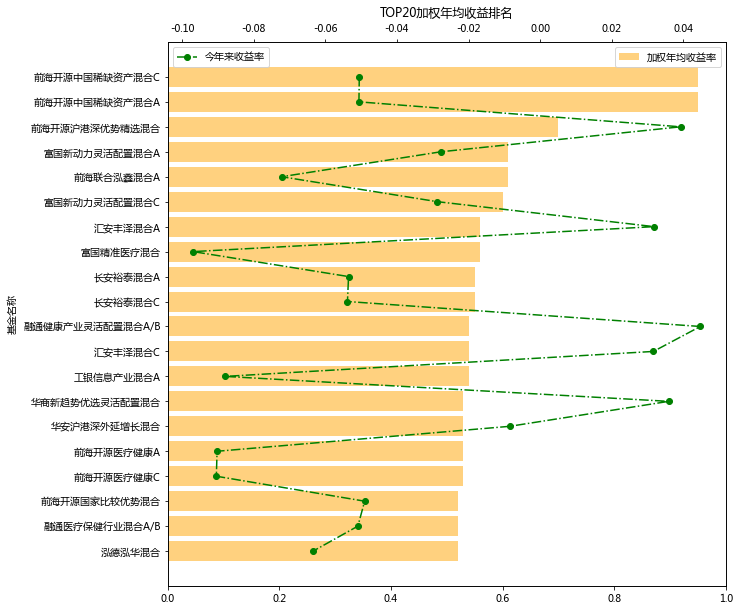

In [141]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax2 = ax1.twiny()

top20_incre = key_point_df.sort_values(['weighted_mean','今年来'],ascending=False).head(20)
ax1.barh(top20_incre['基金名称'], top20_incre['weighted_mean'], color='orange', label='加权年均收益率',alpha=0.5);
ax2.plot(top20_incre['今年来'],top20_incre['基金名称'],'g-.',marker='o',label='今年来收益率')
ax1.set(ylabel='基金名称',
      title='TOP20加权年均收益排名',
      xticks=np.arange(0,1.2,0.2))
ax2.set(xticks=np.arange(-0.1,0.06,0.02))
fig.subplots_adjust(wspace=0.5,hspace=1.5)
ax1.invert_yaxis()
ax1.legend(loc=1)
ax2.legend(loc=2);

综合加权年均收益率和今年来的收益率，以下基金不管在退潮期的抗风险能力还是上升期的稳定增长，表现较为优秀的有：
- 前海开源中国稀缺资产混合A/C
- 前海开源沪港深优势精选混合
- 富国新动力灵活配置混合A/C
- 汇安丰泽混合A/C
- 华商新趋势优选灵活配置混合
- 华安沪港深外延增长混合

### 长期收益Top20在中短期的收益变化

In [266]:
# 选择供该部分分析的数据属性
sort_by_year = fund_rank_df.sort_values(['近3年','近2年'],ascending=False)

# 对每一列降序排名
sort_by_year.iloc[:,2:] = sort_by_year.iloc[:,2:].apply(lambda x:round(x.rank(ascending=False),0))

# 选择前20
longterm_top20 = sort_by_year.head(20)

In [276]:
longterm_top20_fund_rank = longterm_top20.set_index('基金名称').drop(labels=['基金代码'],axis=1).unstack().reset_index(name='排名').rename(columns={'level_0':'收益率名称'})

In [278]:
longterm_top20_fund_rank.to_csv('longterm_top20_fund_rank.csv',encoding='gbk',index=False)

将以上导出的`visual_fund20_rank.csv`作为数据集，使用Tableau可视化出近两年累计收益率在TOP20的基金在不同时间段的收益变化趋势，可视化结果已分享到Tableau Public平台，点击下方链接即可查看:  
[2020年第四季度基金收益变化趋势](https://public.tableau.com/profile/novel6911#!/vizhome/2021_16160739746280/2021?publish=yes)

有可视化结果可知：
- 过去3年内长期累计收益率较高的基金，从近6个月起，增速开始放缓，特别是近1-3月出现了大幅度的回撤，如：前海开源医疗健康A/C、前海联合弘信混合C、工银信息产业混合、富国精准医疗混合
- 而长期收益一般的，近期获取相对较高收益的，如：华商新趋势优选灵活配置混合、
- 部分基金短中长期表现都相对较平稳：前海开源中国稀缺资产混合A/C、汇安丰泽混合A/C、长安裕泰混合A/C
- 配置了部分港股的基金，近期收益相对较好，如：前海开源沪港深优势精选混合、华安沪港深外延增长混合、
**综上所述，可以看出基金收益具有明显的周期性，基金对标的是股票市场，所以股票市场的投资很多时候是产业轮动的，基金对于各种主题的投资如果偏科严重可能会导致收益波动较大，如需追求长期收益稳定的基金，应该选择较为混合的基金进行配置。而对于短期涨幅较大的基金或产业，应该谨慎投资，因为此时市场是风险大于机会了。**

### 基金收益占比对比

In [283]:
# 自定义堆积柱形图
def stack_barh(results, category_names, figsize):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    figsize: tuple of width and height
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

In [294]:
key_point_df.head()

,基金代码,基金名称,今年来,1st_year,2nd_year,3rd_year,weighted_mean
0,000336,农银研究精选混合,-0.0931,1.1610,0.8135,-0.4381,0.50
40,002132,广发鑫享混合,0.0151,0.9299,0.9028,-0.4790,0.43
80,001679,前海开源中国稀缺资产混合A,-0.0506,0.9933,0.7905,1.0480,0.95
120,002079,前海开源中国稀缺资产混合C,-0.0505,0.9917,0.7870,1.0403,0.95
160,002939,广发创新升级混合,-0.0572,0.4419,1.3013,-0.2349,0.46


In [300]:
# 构建一个字典

stack_incre_dict = dict()
chart2_df = key_point_df[['基金名称','1st_year', '2nd_year', '3rd_year']].set_index('基金名称')
for index, value in zip(chart2_df.index, chart2_df.values):
    stack_incre_dict[index] = value

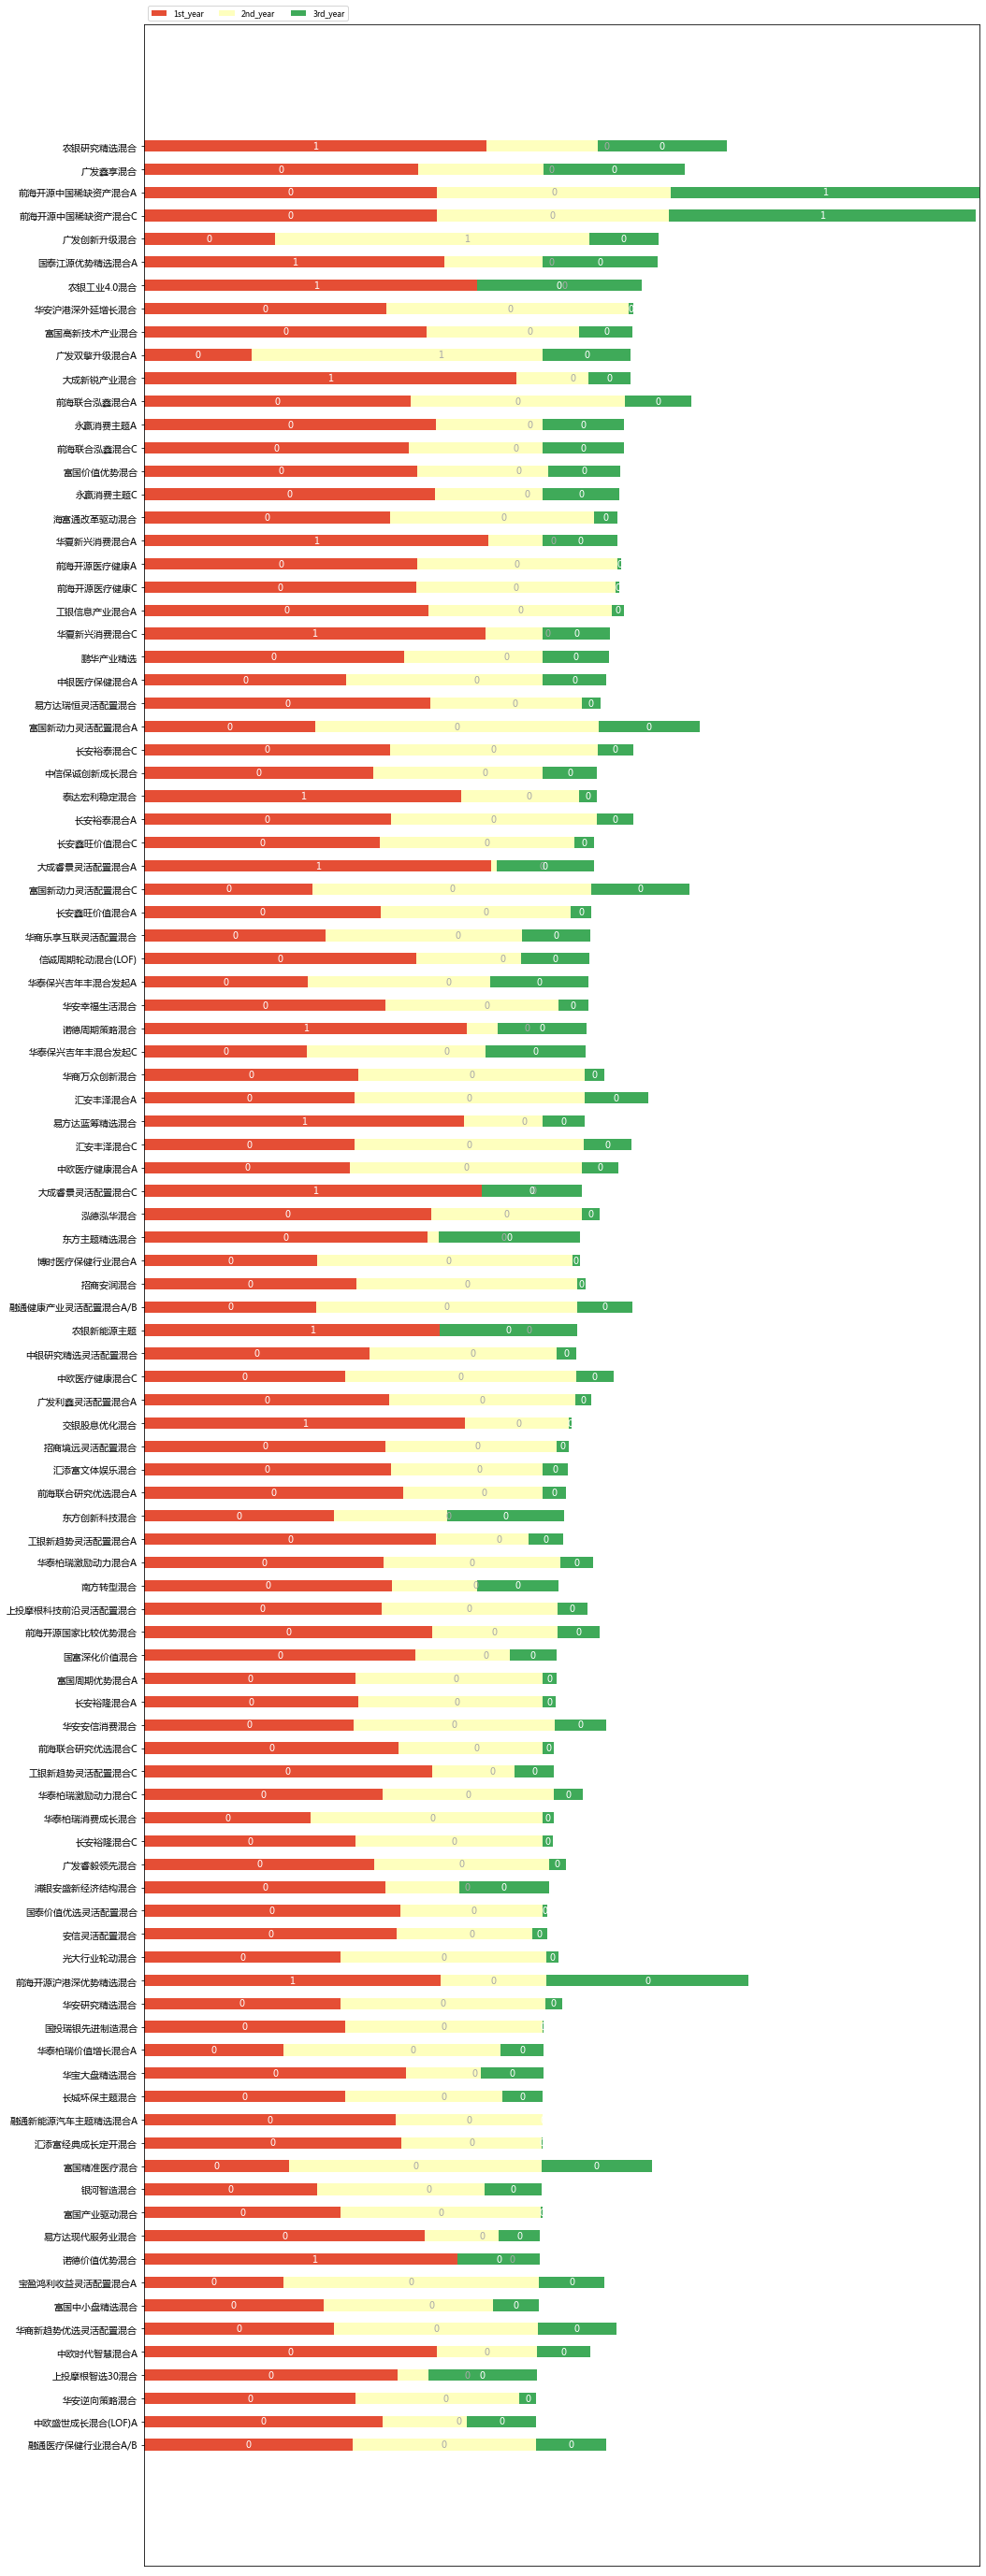

In [302]:
stack_barh(stack_incre_dict,category_names=[ '1st_year', '2nd_year', '3rd_year'],figsize=(16,50));

1. 从上图能够很直观地看出，大部分基金近3年的累计收益主要得益于近2年的累计收益，2018年大部分基金都处于亏损状态，2019年开始大面积回暖，2020年大幅增长且上涨行情持续全年，直至近期才有所回落
- 从上图基金不同年份的收益占比分布可以看出，大部分基金在不同年份的收益占比存在着此消彼长的规律  

**以上说明了股票市场轮动机制显著，大部分时间在进行着产业与产业之间的轮动投资，所以如果进行基金或股票的投资，稳健做法就是分散投资，切忌把所有的鸡蛋放在同一个篮子里**

## 股票部分
- 股票部分
    - 近期基金对于个股的持仓变化，比如青睐哪些个股？
    - 能否从基金持仓数据中展现产业发展趋势？
    - 有哪些投资股票的建议？

### 最新季度二十大基金重仓股票排名

In [170]:
f_s_df.head(1)

,基金代码,基金链接,基金名称,日期,日增长率,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来,股票代码,股票名称,占净值比例,持股数,持仓市值,持仓截止日期
0,000336,http://fund.eastmoney.com/000336.html,农银研究精选混合,03-16,0.0071,0.0141,-0.1794,0.0369,0.2269,1.161,1.9745,1.5364,-0.0931,2.3282,000733,振华科技,0.0764,355.97,20948.96,2020-12-31


In [213]:
recent_q_df = f_s_df[f_s_df['持仓截止日期'] == f_s_df['持仓截止日期'].max()]
recent_q_sh= recent_q_df.groupby(['股票名称']).agg({'股票名称':'count','占净值比例':'mean'}).rename(columns={'股票名称':'重仓基金数','占净值比例':'基金平均持仓占比'}).reset_index()

将重仓基金数和基金平均持仓占比归一化

创建`持仓评分`指标，计算`重仓基金数`和`基金平均持仓占比`的调和平均数，从而综合评估基金对股票的持仓情况：
$$ 持仓评分 = 2\times\frac{归一化的重仓机构数*归一化的基金平均持仓占比}{归一化的重仓机构数+归一化的基金平均持仓占比}$$

In [214]:
# 创建以调和平均数为计算方法的持仓评分指标
from sklearn.preprocessing import MinMaxScaler

def create_ss_score(df,feature1,feature2,create_feature_name):
    '''
    df - (DataFrame) The dataset contains data that need to scale.
    feature1 - (str) column1 of df that need to scale
    feature2 - (str) column2 of df that need to scale
    create_feature_name: The column name that rank fund shareholds 
    '''
    scale = MinMaxScaler()
    df[[feature1,feature2]] = scale.fit_transform(df[[feature1,feature2]])
    df[create_feature_name] = 2*(df[feature1]*df[feature2])/(df[feature1]+df[feature2])

In [219]:
recent_q_sh_copy = recent_q_sh.copy()
create_ss_score(recent_q_sh_copy,'重仓基金数','基金平均持仓占比','持仓评分')

In [220]:
recent_q_sh_copy.head()

,股票名称,重仓基金数,基金平均持仓占比,持仓评分
0,ST抚钢,0.068182,0.118393,0.086531
1,一心堂,0.000000,0.858684,0.000000
2,一拖股份,0.000000,0.186624,0.000000
3,七一二,0.022727,0.241640,0.041547
4,万华化学,0.045455,0.400935,0.081652


In [222]:
top20_cc_rank = recent_q_sh_copy.sort_values('持仓评分',ascending=False).iloc[:20]

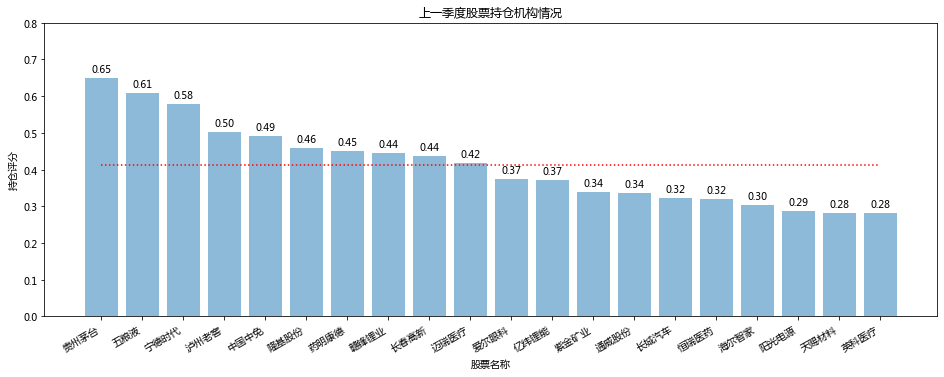

In [223]:
fig,ax = plt.subplots(figsize=(16,6))
x = top20_cc_rank['股票名称']
y1 = top20_cc_rank['持仓评分']
ax.bar(x,y1,alpha=0.5)
ax.set(xlabel='股票名称',
      ylabel='持仓评分',
      title='上一季度股票持仓机构情况',
      ylim=(0,0.8))
for a,b in zip(np.arange(len(x)),y1):
    ax.text(a,b+0.015,'%.2f'%b,fontsize=10,horizontalalignment='center')
ax.hlines(y=y1.mean(),xmin=0,xmax=19,colors='r',linestyles='dotted')
fig.autofmt_xdate(rotation=30);

1. 2020年四季度基金对***贵州茅台、五粮液、宁德时代、泸州老窖、中国中满、隆基股份***较为看好
    1. 机构仍对***高端白酒行业***较为青睐，前6大重仓股中有3只股票属于高端白酒行业：贵州茅台、五粮液和泸州老窖，说明机构长期看好该行业的龙头企业；
    2. 相较与对医疗行业上一季度的保守态度，（见上一季度分析报告`20201124`），机构增加了对**医疗行业**龙头企业的持股占比，如药明康德、长春高新、迈瑞医疗、爱尔眼科、恒瑞医药、英科医疗；
- 根据上图重仓股的行业分布来看，机构仍旧看好**高端白酒、医疗医药、新能源（光伏/锂能）**行业的龙头企业，投资者可以重点关注这几个方向的龙头企业，如股票最近涨幅过大，切忌不要追高，等回调至一定幅度再进行投资。
    1. 相较于上一季度，机构增加了对**有色、化工**行业的投资，如紫金矿业、天赐材料
    - 相较于上一季度，机构减少了对**消费电子**的持股数量和比重，如立讯精密、歌尔股份（详情可参照`20201124`报告）

### 环比季度持仓变化趋势
环比基金二十大重仓股票在每个季度与上一季度对比的持仓变化和趋势

In [224]:
q_sh = f_s_df.groupby(['持仓截止日期','股票名称']).agg({'股票名称':'count','占净值比例':'mean'}).rename(columns={'股票名称':'重仓基金数','占净值比例':'基金平均持仓占比'})
q_sh_copy = q_sh.copy()

In [226]:
create_ss_score(q_sh_copy,'重仓基金数','基金平均持仓占比','持仓评分')

In [46]:
q_sh_copy.head()

重仓基金数  基金平均持仓占比      持仓评分
持仓截止日期     股票名称                              
2020-03-31 一心堂   0.000000  0.478365  0.000000
           万兴科技  0.000000  0.528846  0.000000
           万华化学  0.000000  0.198317  0.000000
           万孚生物  0.000000  0.270433  0.000000
           万科A   0.139535  0.381868  0.204387

In [227]:
# 按照持仓评分进行季度环比，探索每个季度二十大重仓股的变化趋势
g = q_sh_copy['持仓评分'].groupby(level=0,group_keys=False)
res= g.apply(lambda x:x.sort_values(ascending=False).head(20))

In [228]:
recent_q_date = datetime.strftime(f_s_df['持仓截止日期'].max(),'%Y-%m-%d')

In [229]:
sh_trend = res.unstack(level=0).sort_values(recent_q_date,ascending=False)

In [258]:
# 下方是使用Tableau绘制BumpChart来体现基金的持仓变化
top20shs_rank = res.reset_index()
file_name = 'top20shs_rank_'+recent_q_date+'.csv'
top20shs_rank.to_csv(file_name,encoding='gbk',index=False)

In [231]:
sh_trend.head()

持仓截止日期,2020-03-31,2020-06-30,2020-09-30,2020-12-31
股票名称,,,,
贵州茅台,0.593553,0.604812,0.583638,0.628159
五粮液,0.340891,0.475603,0.537049,0.589133
宁德时代,0.278750,0.527251,0.491400,0.555295
泸州老窖,NaN,NaN,0.392073,0.482513
中国中免,NaN,0.261992,0.317589,0.468595


使用两种方式可视化基金的持仓变化，如下：
1. `plotSlope`是一个开源的旨在可视化***BumpChart***的脚本文件，来源于[pascal-schetelat/Github](https://github.com/pascal-schetelat/Slope)
```python
from plotSlope import slope
```
- 使用`Tableau`操作***BumpChart***，可视化结果已分享到Tableau Public平台，点击下方链接即可查看  
[2020年基金重仓股趋势分析](https://public.tableau.com/profile/novel6911#!/vizhome/2020TOP20/2020TOP20?publish=yes)  

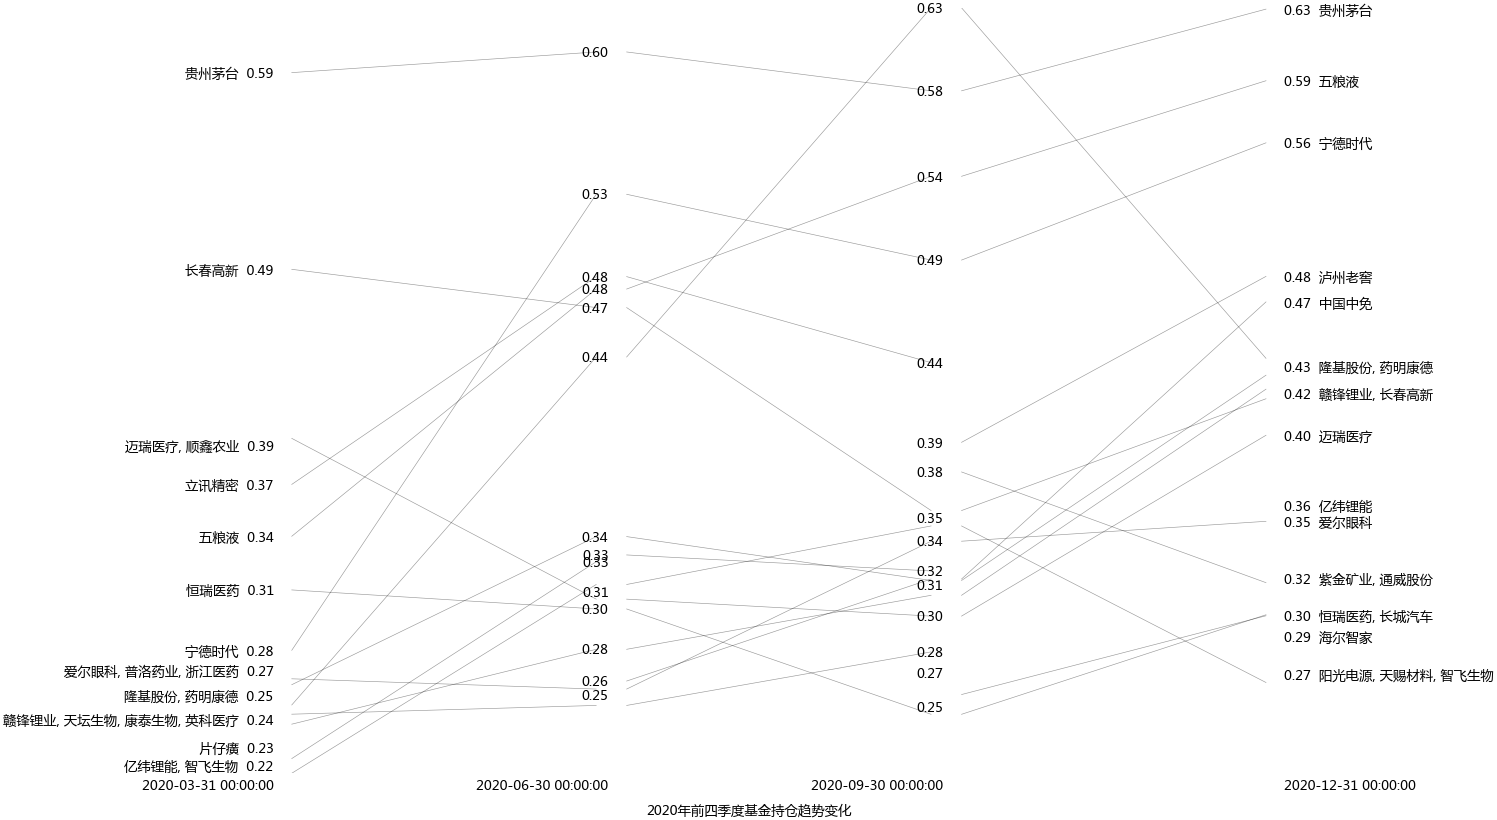

In [249]:
# 下面用plotSlope绘制的bump_chart来体现基金的持仓变化
f = slope(sh_trend,font_family='Microsoft YaHei',marker='%.2f',font_size=32 ,height=28,width=50,title='2020年前四季度基金持仓趋势变化',dpi=100)

通过以上两种可视化方式探索分析可得：

1. 基金持续重仓的个股：
    - 贵州茅台
    - 五粮液
    - 宁德时代
- 基金连续增持的个股：
    - 中国中免
    - 泸州老窖
    - 赣锋锂业
- 基金稳定持有的个股：
    - 药明康德
    - 迈瑞医疗
    - 爱尔眼科
    - 恒瑞医药
- 基金较上一季度大幅减持的个股：
    - 立讯精密
    - 隆基股份
    - 智飞生物
    - 通威股份

从以上所涉及的行业领域划分来看：
1. 基金维持着对高端白酒行业龙头企业的高比重操作，说明基金持续稳定地看好此类企业的长期投资价值；
- 基金重持了对医疗医药行业的信心，相较上一季度，增持了部分医药行业的龙头企业，如药明康德、迈瑞医药、爱尔眼科、恒瑞医药、长春高新，从整个2020年的持仓变化可以看出，对于上述医药行业龙头，呈现强者恒强的局面：
    1. 基金对医药行业不同赛道的不同企业在持仓态度上存在较大的分化，如，但对康泰生物、普洛药业、浙江医药、华兰生物等，只在2020年1季度重仓了这些医药个股，而该季度恰逢疫情爆发高峰，所以投资者在投资时需要区分好成长股、周期股、题材股和因部分不可抗力而导致的投资；
- 基金依然较为稳定地持有新能源行业的股份，如锂能电池行业，但减持对光伏产业的股份，如隆基股份、通威股份；
- 相较于上一季度，机构增加了对有色、化工行业的投资，如紫金矿业、天赐材料；
- 相较于上一季度，机构大量减少了对消费电子的持仓，如立讯精密、歌尔股份；    

# 结论与建议

## 基金部分
1. 综合加权年均收益率和今年来的收益率，以下基金不管在退潮期的抗风险能力还是上升期的稳定增长，表现较为优秀的有：
    - 前海开源中国稀缺资产混合A/C
    - 前海开源沪港深优势精选混合
    - 富国新动力灵活配置混合A/C
    - 汇安丰泽混合A/C
    - 华商新趋势优选灵活配置混合
    - 华安沪港深外延增长混合

2. 通过Tableau`Bar chart`可以看出：
    - 过去3年内长期累计收益率较高的基金，从近6个月起，增速开始放缓，特别是近1-3月出现了大幅度的回撤，如：前海开源医疗健康A/C、前海联合弘信混合C、工银信息产业混合、富国精准医疗混合
    - 而长期收益一般的，近期获取相对较高收益的，如：华商新趋势优选灵活配置混合、
    - 部分基金短中长期表现都相对较平稳：前海开源中国稀缺资产混合A/C、汇安丰泽混合A/C、长安裕泰混合A/C
    - 配置了部分港股的基金，近期收益相对较好，如：前海开源沪港深优势精选混合、华安沪港深外延增长混合
3. 通过`stack_bar`直观地看出:
    - 大部分基金近3年的累计收益主要得益于近2年的累计收益，2018年大部分基金都处于亏损状态，2019年开始大面积回暖，2020年大幅增长且上涨行情持续全年，直至近期才有所回落
    - 从上图基金不同年份的收益占比分布可以看出，大部分基金在不同年份的收益占比存在着此消彼长的规律  

**基金投资建议：**可以看出基金收益具有明显的周期性，基金对标的是股票市场，所以股票市场的投资很多时候是产业轮动的，基金对于各种主题的投资如果偏科严重可能会导致收益波动较大，如需追求长期收益稳定的基金，应该选择较为混合的基金进行配置。而对于短期涨幅较大的基金或产业，应该谨慎投资，因为此时市场是风险大于机会了。

## 股票部分

1. 2020年四季度基金对***贵州茅台、五粮液、宁德时代、泸州老窖、中国中满、隆基股份***较为看好
    1. 机构仍对***高端白酒行业***较为青睐，前6大重仓股中有3只股票属于高端白酒行业：贵州茅台、五粮液和泸州老窖，说明机构长期看好该行业的龙头企业；
    2. 相较与对医疗行业上一季度的保守态度，（见上一季度分析报告`20201124`），机构增加了对**医疗行业**龙头企业的持股占比，如药明康德、长春高新、迈瑞医疗、爱尔眼科、恒瑞医药、英科医疗；
- 根据上图重仓股的行业分布来看，机构仍旧看好**高端白酒、医疗医药、新能源（光伏/锂能）**行业的龙头企业，投资者可以重点关注这几个方向的龙头企业，如股票最近涨幅过大，切忌不要追高，等回调至一定幅度再进行投资。
    1. 相较于上一季度，机构增加了对**有色、化工**行业的投资，如紫金矿业、天赐材料
    - 相较于上一季度，机构减少了对**消费电子**的持股数量和比重，如立讯精密、歌尔股份（详情可参照`20201124`报告）
2. 从以上所涉及的行业领域综合论述：
    1. 基金维持着对高端白酒行业龙头企业的高比重操作，说明基金持续稳定地看好此类企业的长期投资价值；
    - 基金重持了对医疗医药行业的信心，相较上一季度，增持了部分医药行业的龙头企业，如药明康德、迈瑞医药、爱尔眼科、恒瑞医药、长春高新，从整个2020年的持仓变化可以看出，对于上述医药行业龙头，呈现强者恒强的局面：
        1. 基金对医药行业不同赛道的不同企业在持仓态度上存在较大的分化，如，但对康泰生物、普洛药业、浙江医药、华兰生物等，只在2020年1季度重仓了这些医药个股，而该季度恰逢疫情爆发高峰，所以投资者在投资时需要区分好成长股、周期股、题材股和因部分不可抗力而导致的投资；
    - 基金依然较为稳定地持有新能源行业的股份，如锂能电池行业，但减持对光伏产业的股份，如隆基股份、通威股份；   

**股票投资建议**：重点关注高端白酒产业的龙头企业，关注新能源产业，特别是光伏、新能源汽车和锂能的龙头企业的企业信息和行业动态，如国家对于该类产业的政策扶持等，医药医疗行业分化较大，谨慎择股。最后，切忌追高。